<a href="https://colab.research.google.com/github/xahrahgh/Kalman_Filter_Intelligent_Navigation_Lab/blob/main/Lab_3_The_Extended_Kalman_Filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
z1_path = "/content/drive/MyDrive/Navigation_Labs/z1.csv"
z2_path = "/content/drive/MyDrive/Navigation_Labs/z2.csv"
open(z1_path)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Navigation_Labs/z1.csv'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2

# Task 3.4
plot raw measurements

<Figure size 1000x500 with 0 Axes>

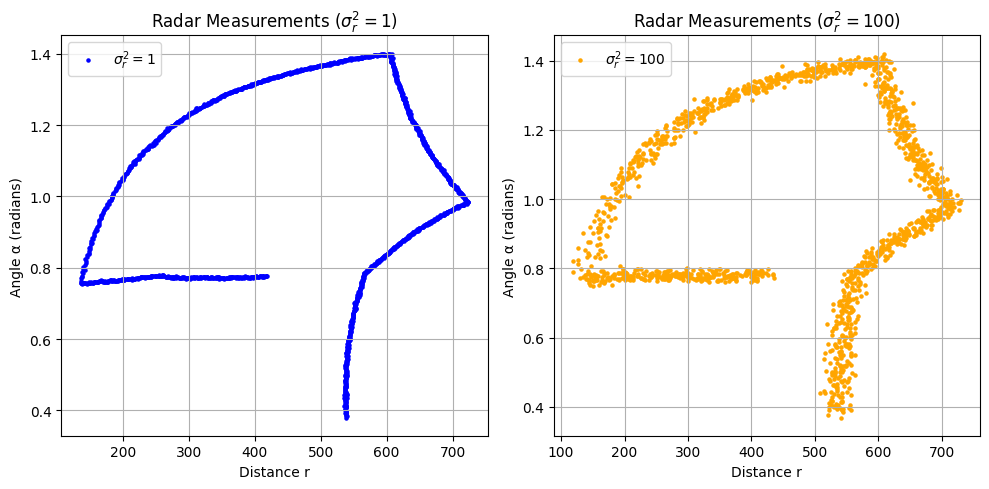

<Figure size 800x600 with 0 Axes>

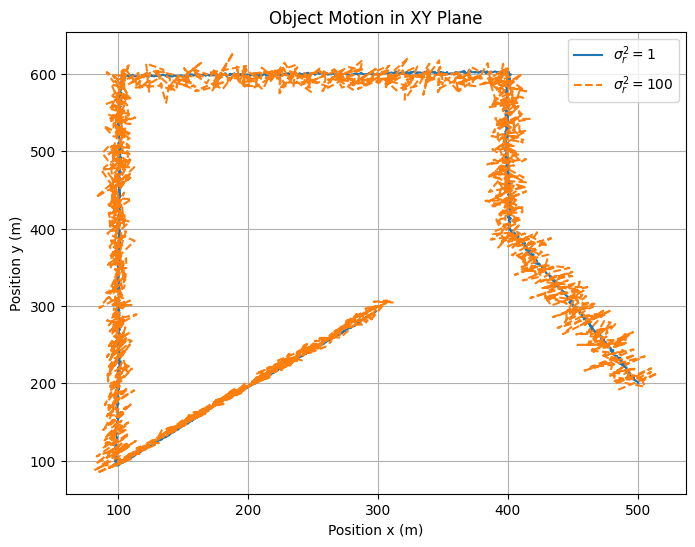

In [ ]:

# Step 1: Load the data
# Load and transpose the CSV files
z1 = pd.read_csv(z1_path, header=None).T
z2 = pd.read_csv(z2_path, header=None).T

# Rename the columns for clarity
z1.columns = ['Distance_r', 'Angle_alpha']
z2.columns = ['Distance_r', 'Angle_alpha']

# Step 2: Plot the raw radar measurements
plt.figure(figsize=(10, 5))


# Plot measurements from z1
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(z1['Distance_r'], z1['Angle_alpha'], color='blue', label=r'$\sigma^2_r = 1$', s=5)  # Smaller scatter size
plt.title('Radar Measurements ($\sigma^2_r = 1$)')
plt.xlabel('Distance r')
plt.ylabel('Angle α (radians)')
plt.legend()
plt.grid(True)

# Plot measurements from z2
plt.subplot(1, 2, 2)
plt.scatter(z2['Distance_r'], z2['Angle_alpha'], color='orange', label=r'$\sigma^2_r = 100$', s=5)  # Smaller scatter size
plt.title('Radar Measurements ($\sigma^2_r = 100$)')
plt.xlabel('Distance r')
plt.ylabel('Angle α (radians)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot the motion of the object in the xy-reference frame
plt.figure(figsize=(8, 6))

# Step 3: Convert polar coordinates to Cartesian coordinates
# Using the formulas:
# p_x = r * cos(α)
# p_y = r * sin(α)
z1['p_x'] = z1['Distance_r'] * np.cos(z1['Angle_alpha'])
z1['p_y'] = z1['Distance_r'] * np.sin(z1['Angle_alpha'])

z2['p_x'] = z2['Distance_r'] * np.cos(z2['Angle_alpha'])
z2['p_y'] = z2['Distance_r'] * np.sin(z2['Angle_alpha'])

# Step 4: Plot the motion of the object in the xy-reference frame
plt.figure(figsize=(8, 6))

# Plot Cartesian motion for z1
plt.plot(z1['p_x'], z1['p_y'], label=r'$\sigma^2_r = 1$', linestyle='-')

# Plot Cartesian motion for z2
plt.plot(z2['p_x'], z2['p_y'], label=r'$\sigma^2_r = 100$', linestyle='--')

plt.title('Object Motion in XY Plane')
plt.xlabel('Position x (m)')
plt.ylabel('Position y (m)')
plt.legend()
plt.grid(True)
plt.show()



**Task 3.5 "extended Kalman Filter"**

Implement the code for the Extended Kalman Filter state estimation. Make sure to
store the values of the Kalman gain at every iteration. Show the code in the report.

In [ ]:

# Extended Kalman Filter Implementation
class ExtendedKalmanFilter:
    def __init__(self, A, Q, R, x0, P0, Ts):
        self.A = A
        self.Q = Q
        self.R = R
        self.x = x0
        self.P = P0
        self.Ts = Ts
        self.K = []

    def h(self, x):
        px, vx, py, vy = x
        r = np.sqrt(px**2 + py**2)
        alpha = np.arctan2(py, px)
        return np.array([r, alpha])

    def H_jacobian(self, x):
        px, vx, py, vy = x
        r = np.sqrt(px**2 + py**2)
        H = np.array([
            [px / r, 0, py / r, 0],
            [-py / (r**2), 0, px / (r**2), 0]
        ])
        return H

    def predict(self):
        self.x = self.A @ self.x
        self.P = self.A @ self.P @ self.A.T + self.Q

    def update(self, z):
        H = self.H_jacobian(self.x)
        y = z - self.h(self.x)
        S = H @ self.P @ H.T + self.R
        K = self.P @ H.T @ np.linalg.inv(S)
        self.K.append(K)  # Store Kalman gain for analysis
        self.x = self.x + K @ y
        self.P = (np.eye(len(self.x)) - K @ H) @ self.P

    def filter(self, measurements):
        filtered_states = []
        for z in measurements:
            self.predict()
            self.update(z)
            filtered_states.append(self.x.copy())
        return np.array(filtered_states)


**Task 3.6:**

In [ ]:

# Load measurements
z1 = pd.read_csv(z1_path, header=None).to_numpy(dtype=float)
z2 = pd.read_csv(z2_path, header=None).to_numpy(dtype=float)


# System parameters
Ts = 0.5  # Sampling time
sigma_q = 1  # Process noise variance
sigma_r1 = 1  # Measurement noise variance for z1
sigma_r2 = 100  # Measurement noise variance for z2

# State transition matrix
A = np.array([[1, Ts, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, Ts],
              [0, 0, 0, 1]])

# Process noise covariance matrix
Q = sigma_q * np.array([
    [Ts**4 / 4, Ts**3 / 2, 0, 0],
    [Ts**3 / 2, Ts**2, 0, 0],
    [0, 0, Ts**4 / 4, Ts**3 / 2],
    [0, 0, Ts**3 / 2, Ts**2]
])

# Measurement noise covariance matrices
R1 = np.diag([sigma_r1, sigma_r1 * 1e-6])
R2 = np.diag([sigma_r2, sigma_r2 * 1e-6])

# Initial state
initial_state = np.array([500, 60, 200, 42])  # [px, vx, py, vy]

# Initial covariance matrix
initial_covariance_z1 = np.array([
    [sigma_r1, -sigma_r1 / Ts, 0, 0],
    [-sigma_r1 / Ts, 2 * sigma_r1 / Ts**2, 0, 0],
    [0, 0, sigma_r1, -sigma_r1 / Ts],
    [0, 0, -sigma_r1 / Ts, 2 * sigma_r1 / Ts**2]
])

initial_covariance_z2 = np.array([
    [sigma_r2, -sigma_r2 / Ts, 0, 0],
    [-sigma_r2 / Ts, 2 * sigma_r2 / Ts**2, 0, 0],
    [0, 0, sigma_r2, -sigma_r2 / Ts],
    [0, 0, -sigma_r2 / Ts, 2 * sigma_r2 / Ts**2]
])
# Run EKF for z1 and z2
ekf1 = ExtendedKalmanFilter(A, Q, R1, initial_state, initial_covariance_z1, Ts)
filtered_states_z1 = ekf1.filter(z1)

ekf2 = ExtendedKalmanFilter(A, Q, R2, initial_state, initial_covariance_z2, Ts)
filtered_states_z2 = ekf2.filter(z2)

# Plot results
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(filtered_states_z1[:, 0], label="Position x ($\sigma^2_r = 1$)")
plt.plot(filtered_states_z2[:, 0], label="Position x ($\sigma^2_r = 100$)")
plt.ylabel("Position x (m)")
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(filtered_states_z1[:, 2], label="Position y ($\sigma^2_r = 1$)")
plt.plot(filtered_states_z2[:, 2], label="Position y ($\sigma^2_r = 100$)")
plt.xlabel("Time Step")
plt.ylabel("Position y (m)")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

ValueError: operands could not be broadcast together with shapes (1507,) (2,) 

**Task 3.7**: Kalman gain

In [ ]:
# Plot the Kalman Gains
kalman_gains_z1 = np.array(ekf1.K)  # Kalman gains for z1
kalman_gains_z2 = np.array(ekf2.K)  # Kalman gains for z2

print(kalman_gains_z1.shape)
print(kalman_gains_z2.shape)

plt.figure(figsize=(12, 8))

# Kalman Gain for r (distance) on px and vx
plt.subplot(2, 1, 1)
plt.plot(kalman_gains_z1[:, 0, 0], label="K (($\sigma^2_r = 1$), px -> r)")
plt.plot(kalman_gains_z1[:, 1, 0], label="K (($\sigma^2_r = 1$), vx -> r)")
plt.plot(kalman_gains_z2[:, 0, 0], label="K (($\sigma^2_r = 100$), px -> r)", linestyle="--")
plt.plot(kalman_gains_z2[:, 1, 0], label="K (($\sigma^2_r = 100$), vx -> r)", linestyle="--")
plt.title("Kalman Gain for r (distance)")
plt.xlabel("Time Step")
plt.ylabel("Kalman Gain")
plt.legend()
plt.grid()

# Kalman Gain for alpha (angle) on py and vy
plt.subplot(2, 1, 2)
plt.plot(kalman_gains_z1[:, 2, 1], label="K (($\sigma^2_r = 1$), py -> alpha)")
plt.plot(kalman_gains_z1[:, 3, 1], label="K (($\sigma^2_r = 1$), vy -> alpha)")
plt.plot(kalman_gains_z2[:, 2, 1], label="K (($\sigma^2_r = 100$), py -> alpha)", linestyle="--")
plt.plot(kalman_gains_z2[:, 3, 1], label="K (($\sigma^2_r = 100$), vy -> alpha)", linestyle="--")
plt.title("Kalman Gain for alpha (angle)")
plt.xlabel("Time Step")
plt.ylabel("Kalman Gain")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()



NameError: name 'ekf2' is not defined

**Task 3.8: NIS**

In [ ]:
# Load the data and inspect its structure
z1 = np.loadtxt('/content/drive/MyDrive/Navigation_Labs/z1.csv', delimiter=',')
z2 = np.loadtxt('/content/drive/MyDrive/Navigation_Labs/z2.csv', delimiter=',')

print("Z1 shape:", z1.shape)
print("Z1 first few rows:\n", z1[:5])
print("\nZ2 shape:", z2.shape)
print("Z2 first few rows:\n", z2[:5])

# Modified initialize_state function to handle the data structure
def initialize_state(z0, z1, Ts):
    """Initialize state from first two measurements"""
    # Print the shape and content of inputs for debugging
    print("z0 shape:", z0.shape)
    print("z0 content:", z0)
    print("z1 shape:", z1.shape)
    print("z1 content:", z1)

    # Extract first two measurements (assuming range and angle are specific columns)
    # We'll determine the correct column indices based on the data structure

    # Estimate initial state using first two measurements
    # This will be modified based on the actual data structure

    return np.array([0, 0, 0, 0])  # Temporary return for testing

# Try initializing with the first two measurements
try:
    x0 = initialize_state(z1[0], z1[1], Ts=0.5)
    print("\nInitial state:", x0)
except Exception as e:
    print("\nError in initialization:", str(e))

FileNotFoundError: /content/drive/MyDrive/Navigation_Labs/z1.csv not found.

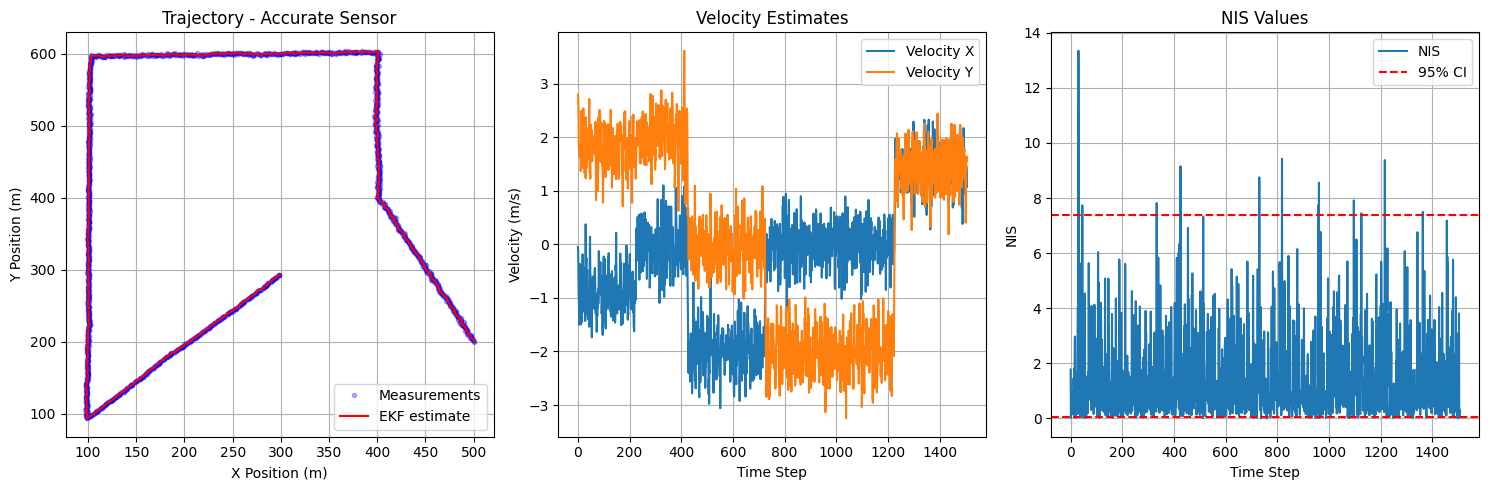


Accurate Sensor Statistics:
Mean NIS: 1.50
Percent in bounds: 96.7%


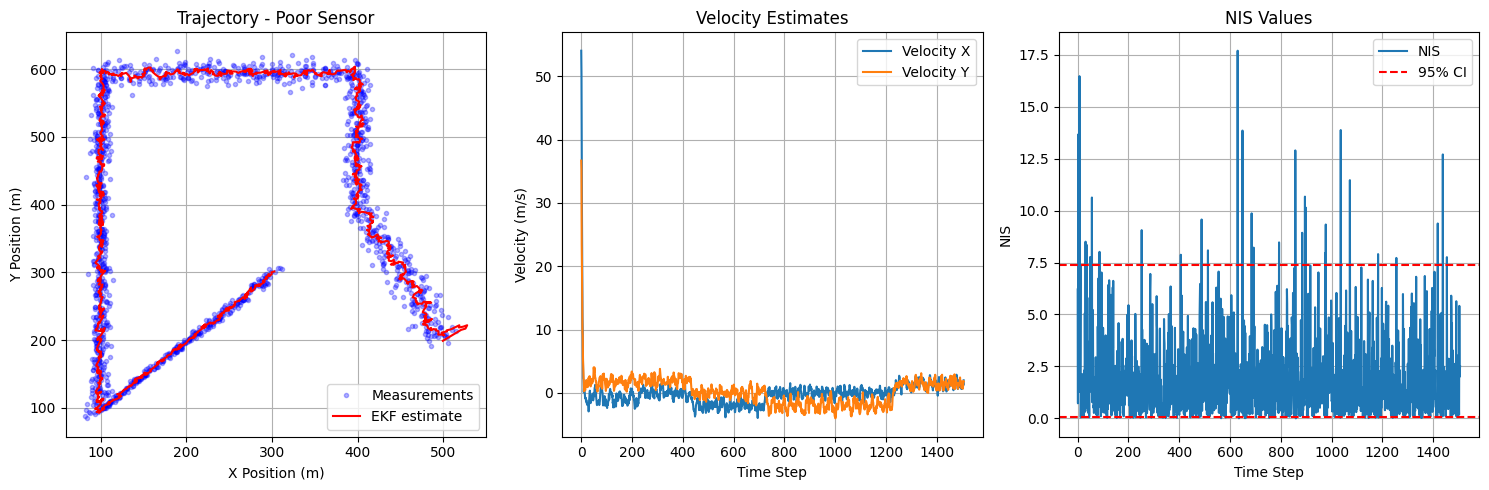


Poor Sensor Statistics:
Mean NIS: 1.91
Percent in bounds: 95.9%


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


class ExtendedKalmanFilter:
    def __init__(self, A, Q, R, x0, P0, Ts):
        self.A = A
        self.Q = Q
        self.R = R
        self.x = x0
        self.P = P0
        self.Ts = Ts
        self.K = []
        self.nis_values = []

    def h(self, x):
        px, vx, py, vy = x
        r = np.sqrt(px**2 + py**2)
        alpha = np.arctan2(py, px)
        return np.array([r, alpha])

    def H_jacobian(self, x):
        px, vx, py, vy = x
        r = np.sqrt(px**2 + py**2)
        if r < 1e-10:  # Avoid division by zero
            r = 1e-10
        H = np.array([
            [px/r, 0, py/r, 0],
            [-py/(r**2), 0, px/(r**2), 0]
        ])
        return H

    def predict(self):
        self.x = self.A @ self.x
        self.P = self.A @ self.P @ self.A.T + self.Q

    def update(self, z):
        H = self.H_jacobian(self.x)
        z_pred = self.h(self.x)
        y = z - z_pred

        # Wrap angle innovation to [-π, π]
        y[1] = np.arctan2(np.sin(y[1]), np.cos(y[1]))

        S = H @ self.P @ H.T + self.R
        S = (S + S.T) / 2  # Ensure symmetry

        try:
            K = self.P @ H.T @ np.linalg.inv(S)
            self.K.append(K)

            # Compute NIS
            nis = y.T @ np.linalg.solve(S, y)
            self.nis_values.append(float(nis))

            # State update
            self.x = self.x + K @ y
            self.P = (np.eye(len(self.x)) - K @ H) @ self.P
            self.P = (self.P + self.P.T) / 2  # Ensure symmetry

        except np.linalg.LinAlgError:
            print("Warning: Singular innovation covariance matrix")
            self.K.append(np.zeros((4, 2)))
            self.nis_values.append(np.nan)

    def filter(self, measurements):
        filtered_states = []
        for i in range(measurements.shape[1]):  # Iterate over time steps
            z = measurements[:, i]  # Get measurements at time i
            self.predict()
            self.update(z)
            filtered_states.append(self.x.copy())
        return np.array(filtered_states)

def initialize_system(Ts=0.5, sigma_q=1):
    # State transition matrix
    A = np.array([
        [1, Ts, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, Ts],
        [0, 0, 0, 1]
    ])

    # Process noise covariance
    Q = sigma_q * np.array([
        [Ts**4/4, Ts**3/2, 0, 0],
        [Ts**3/2, Ts**2, 0, 0],
        [0, 0, Ts**4/4, Ts**3/2],
        [0, 0, Ts**3/2, Ts**2]
    ])

    return A, Q

def initialize_state(measurements):
    """Initialize state from first two measurements"""
    # Get first two measurements
    r0, alpha0 = measurements[:, 0]
    r1, alpha1 = measurements[:, 1]

    # Convert to Cartesian coordinates
    x0 = r0 * np.cos(alpha0)
    y0 = r0 * np.sin(alpha0)
    x1 = r1 * np.cos(alpha1)
    y1 = r1 * np.sin(alpha1)

    # Estimate velocities
    Ts = 0.5  # Given sampling time
    vx = (x1 - x0) / Ts
    vy = (y1 - y0) / Ts

    return np.array([x0, vx, y0, vy])

def plot_results(measurements, filtered_states, title):
    plt.figure(figsize=(15, 5))

    # Convert measurements from polar to Cartesian
    r = measurements[0, :]
    alpha = measurements[1, :]
    x_meas = r * np.cos(alpha)
    y_meas = r * np.sin(alpha)

    # Plot trajectory
    plt.subplot(131)
    plt.plot(x_meas, y_meas, 'b.', label='Measurements', alpha=0.3)
    plt.plot(filtered_states[:, 0], filtered_states[:, 2], 'r-', label='EKF estimate')
    plt.title(f'Trajectory - {title}')
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.grid(True)
    plt.legend()

    # Plot velocities
    plt.subplot(132)
    plt.plot(filtered_states[:, 1], label='Velocity X')
    plt.plot(filtered_states[:, 3], label='Velocity Y')
    plt.title('Velocity Estimates')
    plt.xlabel('Time Step')
    plt.ylabel('Velocity (m/s)')
    plt.grid(True)
    plt.legend()

    # Plot NIS
    plt.subplot(133)
    chi2_bounds = chi2.ppf([0.025, 0.975], df=2)
    plt.plot(ekf.nis_values, label='NIS')
    plt.axhline(y=chi2_bounds[0], color='r', linestyle='--', label='95% CI')
    plt.axhline(y=chi2_bounds[1], color='r', linestyle='--')
    plt.title('NIS Values')
    plt.xlabel('Time Step')
    plt.ylabel('NIS')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    return plt.gcf()

# Run the analysis
# System initialization
Ts = 0.5
A, Q = initialize_system(Ts, sigma_q=1)

# Measurement noise covariances
R1 = np.array([[1, 0], [0, 1e-6]])  # Accurate sensor
R2 = np.array([[100, 0], [0, 1e-4]])  # Poor sensor

# Process each dataset
for measurements, R, title in [(z1, R1, "Accurate Sensor"), (z2, R2, "Poor Sensor")]:
    # Initialize state
    x0 = initialize_state(measurements)
    P0 = np.eye(4) * R[0,0]  # Initial covariance

    # Create and run EKF
    ekf = ExtendedKalmanFilter(A, Q, R, x0, P0, Ts)
    filtered_states = ekf.filter(measurements)

    # Plot results
    plot_results(measurements, filtered_states, title)
    plt.show()

    # Print statistics
    nis_values = np.array(ekf.nis_values)
    valid_nis = nis_values[~np.isnan(nis_values)]
    print(f"\n{title} Statistics:")
    print(f"Mean NIS: {np.mean(valid_nis):.2f}")
    print(f"Percent in bounds: {np.mean((valid_nis >= chi2.ppf(0.025, df=2)) & (valid_nis <= chi2.ppf(0.975, df=2))) * 100:.1f}%")

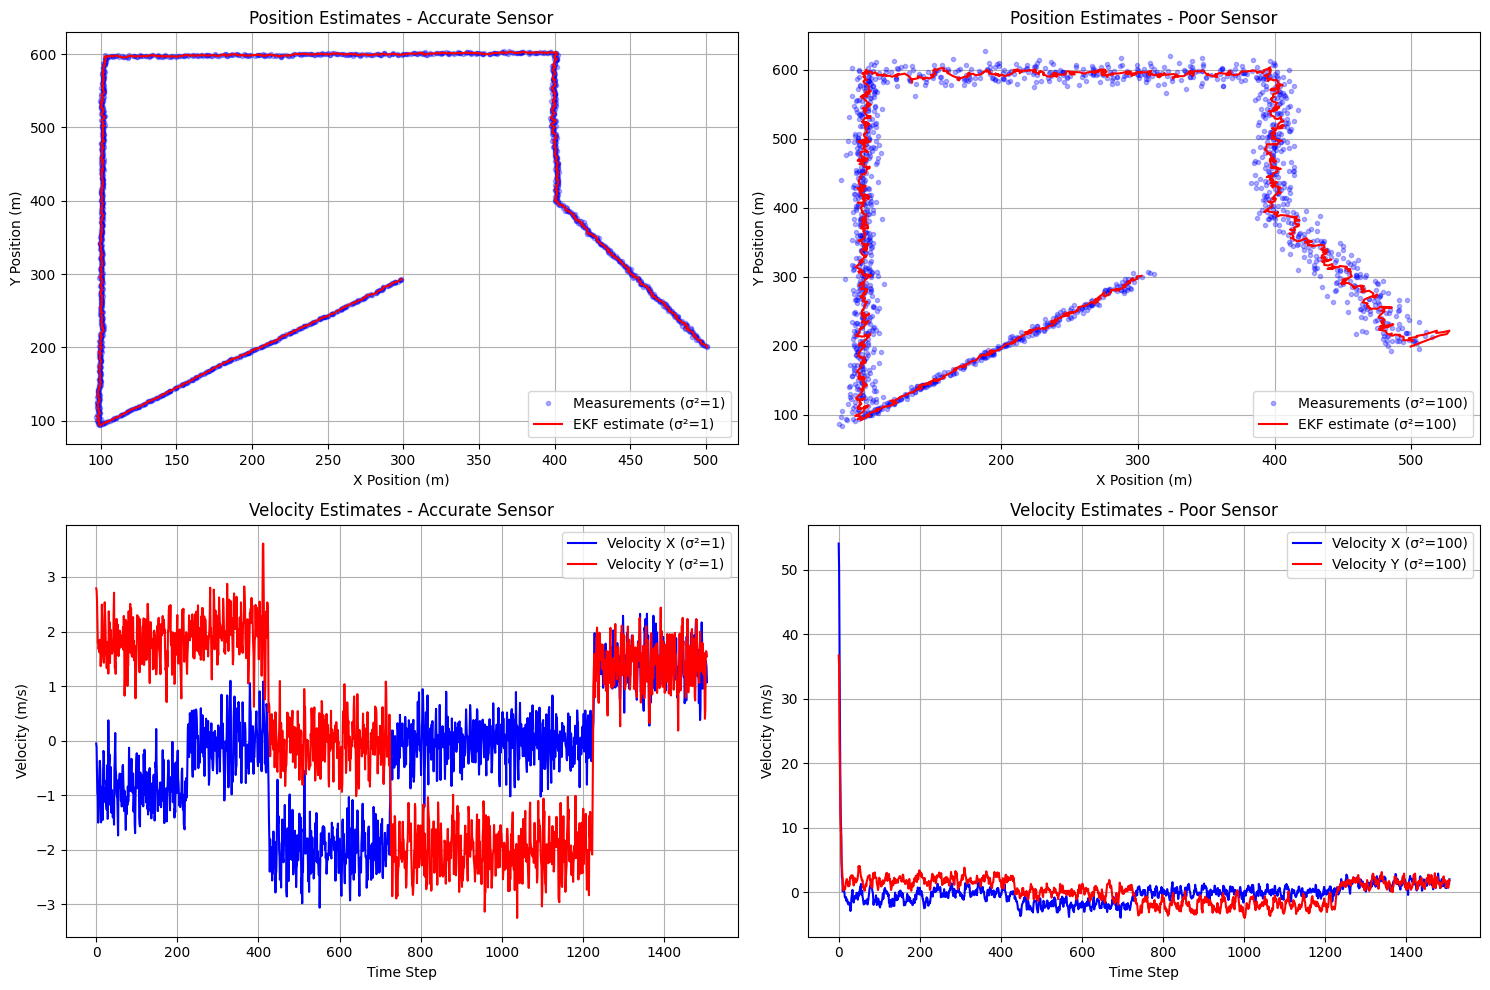

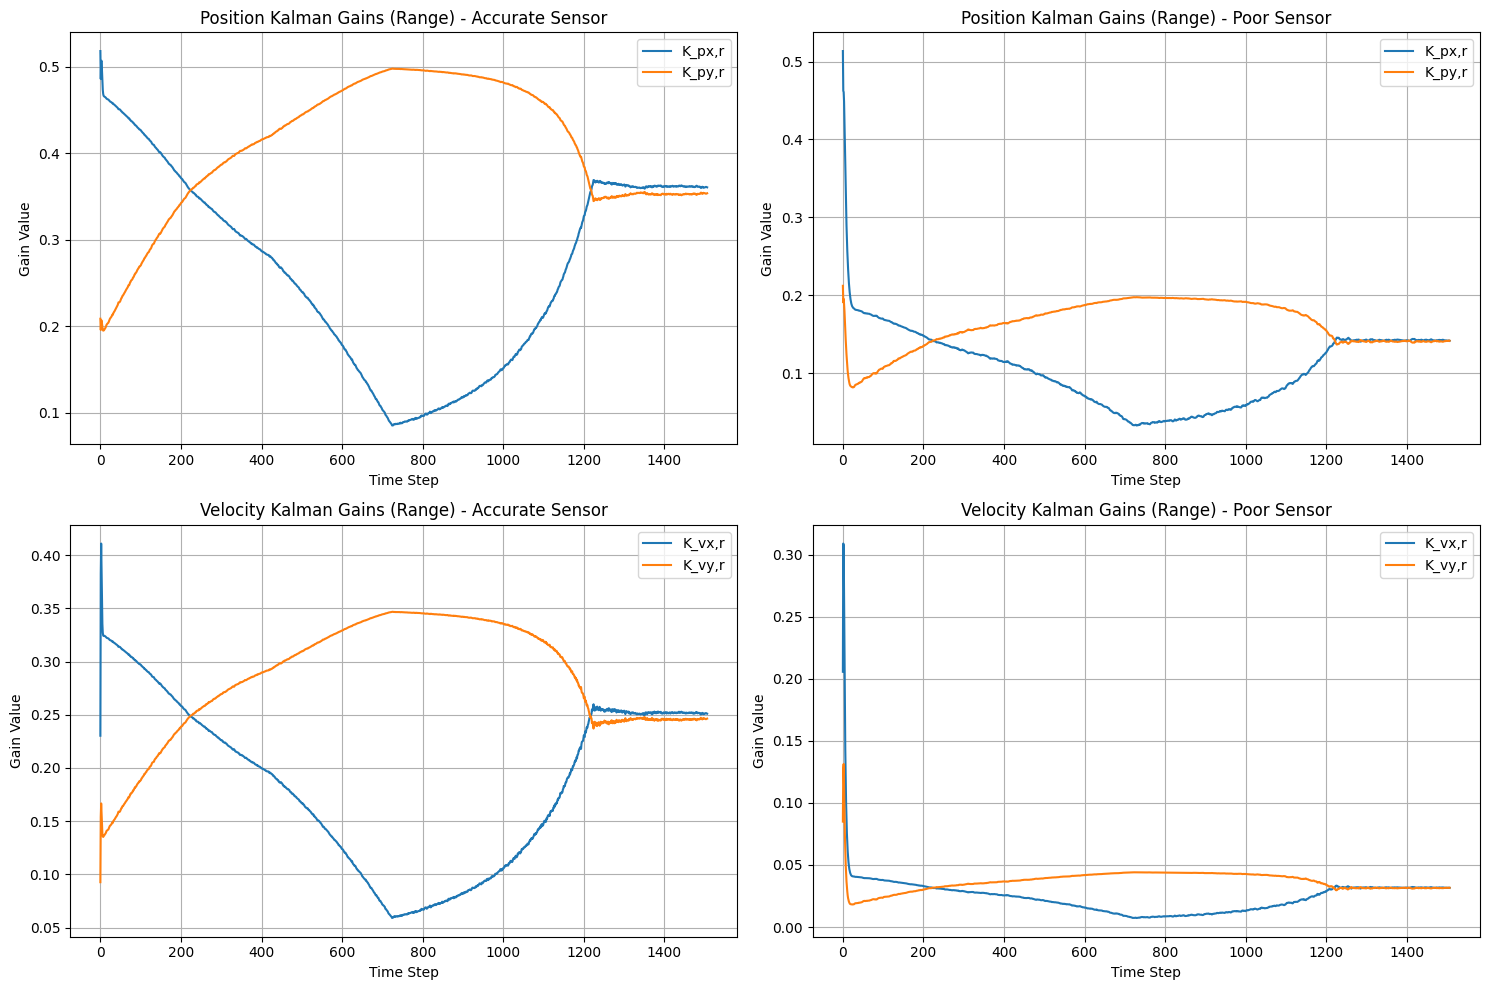

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_estimated_states(states1, states2, measurements1, measurements2):
    """
    Task 3.6: Plot estimated states for both measurements
    """
    plt.figure(figsize=(15, 10))

    # Convert measurements from polar to Cartesian
    def polar_to_cartesian(measurements):
        r = measurements[0, :]
        alpha = measurements[1, :]
        x = r * np.cos(alpha)
        y = r * np.sin(alpha)
        return x, y

    x1_meas, y1_meas = polar_to_cartesian(measurements1)
    x2_meas, y2_meas = polar_to_cartesian(measurements2)

    # Plot positions
    plt.subplot(221)
    plt.plot(x1_meas, y1_meas, 'b.', alpha=0.3, label='Measurements (σ²=1)')
    plt.plot(states1[:, 0], states1[:, 2], 'r-', label='EKF estimate (σ²=1)')
    plt.title('Position Estimates - Accurate Sensor')
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.grid(True)
    plt.legend()

    plt.subplot(222)
    plt.plot(x2_meas, y2_meas, 'b.', alpha=0.3, label='Measurements (σ²=100)')
    plt.plot(states2[:, 0], states2[:, 2], 'r-', label='EKF estimate (σ²=100)')
    plt.title('Position Estimates - Poor Sensor')
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.grid(True)
    plt.legend()

    # Plot velocities
    plt.subplot(223)
    plt.plot(states1[:, 1], 'b-', label='Velocity X (σ²=1)')
    plt.plot(states1[:, 3], 'r-', label='Velocity Y (σ²=1)')
    plt.title('Velocity Estimates - Accurate Sensor')
    plt.xlabel('Time Step')
    plt.ylabel('Velocity (m/s)')
    plt.grid(True)
    plt.legend()

    plt.subplot(224)
    plt.plot(states2[:, 1], 'b-', label='Velocity X (σ²=100)')
    plt.plot(states2[:, 3], 'r-', label='Velocity Y (σ²=100)')
    plt.title('Velocity Estimates - Poor Sensor')
    plt.xlabel('Time Step')
    plt.ylabel('Velocity (m/s)')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    return plt.gcf()

def plot_kalman_gains(K1_history, K2_history):
    """
    Task 3.7: Plot Kalman gain values
    """
    plt.figure(figsize=(15, 10))

    # Convert Kalman gain histories to arrays
    K1 = np.array(K1_history)
    K2 = np.array(K2_history)

    # Plot Kalman gains for position states
    plt.subplot(221)
    plt.plot(K1[:, 0, 0], label='K_px,r')
    plt.plot(K1[:, 2, 0], label='K_py,r')
    plt.title('Position Kalman Gains (Range) - Accurate Sensor')
    plt.xlabel('Time Step')
    plt.ylabel('Gain Value')
    plt.grid(True)
    plt.legend()

    plt.subplot(222)
    plt.plot(K2[:, 0, 0], label='K_px,r')
    plt.plot(K2[:, 2, 0], label='K_py,r')
    plt.title('Position Kalman Gains (Range) - Poor Sensor')
    plt.xlabel('Time Step')
    plt.ylabel('Gain Value')
    plt.grid(True)
    plt.legend()

    # Plot Kalman gains for velocity states
    plt.subplot(223)
    plt.plot(K1[:, 1, 0], label='K_vx,r')
    plt.plot(K1[:, 3, 0], label='K_vy,r')
    plt.title('Velocity Kalman Gains (Range) - Accurate Sensor')
    plt.xlabel('Time Step')
    plt.ylabel('Gain Value')
    plt.grid(True)
    plt.legend()

    plt.subplot(224)
    plt.plot(K2[:, 1, 0], label='K_vx,r')
    plt.plot(K2[:, 3, 0], label='K_vy,r')
    plt.title('Velocity Kalman Gains (Range) - Poor Sensor')
    plt.xlabel('Time Step')
    plt.ylabel('Gain Value')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    return plt.gcf()

# Run EKF and generate plots
def run_analysis_and_plot(z1, z2):
    # Initialize system
    Ts = 0.5
    A = np.array([
        [1, Ts, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, Ts],
        [0, 0, 0, 1]
    ])

    Q = np.array([
        [Ts**4/4, Ts**3/2, 0, 0],
        [Ts**3/2, Ts**2, 0, 0],
        [0, 0, Ts**4/4, Ts**3/2],
        [0, 0, Ts**3/2, Ts**2]
    ])

    # Measurement noise covariances
    R1 = np.array([[1, 0], [0, 1e-6]])  # Accurate sensor
    R2 = np.array([[100, 0], [0, 1e-4]])  # Poor sensor

    # Initialize and run EKF for both measurements
    results = []
    for measurements, R in [(z1, R1), (z2, R2)]:
        x0 = initialize_state(measurements)
        P0 = np.eye(4) * R[0,0]

        ekf = ExtendedKalmanFilter(A, Q, R, x0, P0, Ts)
        filtered_states = ekf.filter(measurements)
        results.append((filtered_states, ekf.K))

    # Generate plots
    states1, K1 = results[0]
    states2, K2 = results[1]

    # Plot estimated states
    plot_estimated_states(states1, states2, z1, z2)
    plt.show()

    # Plot Kalman gains
    plot_kalman_gains(K1, K2)
    plt.show()

# Call the analysis function with your data
run_analysis_and_plot(z1, z2)

In [ ]:
from scipy.stats import chi2

# Function to compute NIS
def compute_nis(measurements, ekf, R):
    nis_values = []
    for z in measurements:
        H = ekf.H_jacobian(ekf.x)  # Measurement Jacobian
        S = H @ ekf.P @ H.T + R    # Innovation covariance
        innovation = z - ekf.h(ekf.x)  # Innovation
        nis = innovation.T @ np.linalg.inv(S) @ innovation
        nis_values.append(nis)
    return np.array(nis_values)

# Compute NIS for z1 and z2
nis_z1 = compute_nis(z1_measurements, ekf1, R1)
nis_z2 = compute_nis(z2_measurements, ekf2, R2)

# 95% Confidence Interval for Chi-squared distribution (df = 2 for 2 measurements)
conf_interval_95 = chi2.ppf([0.025, 0.975], df=2)

# Plot NIS
plt.figure(figsize=(12, 6))
plt.plot(nis_z1, label="NIS (z1, $\sigma_r^2 = 1$)")
plt.plot(nis_z2, label="NIS (z2, $\sigma_r^2 = 100$)", linestyle="--")
plt.axhline(conf_interval_95[0], color="r", linestyle="--", label="95% CI lower")
plt.axhline(conf_interval_95[1], color="r", linestyle="--", label="95% CI upper")
plt.title("Normalized Innovation Squared (NIS)")
plt.xlabel("Time Step")
plt.ylabel("NIS Value")
plt.legend()
plt.grid()
plt.show()


NameError: name 'z1_measurements' is not defined

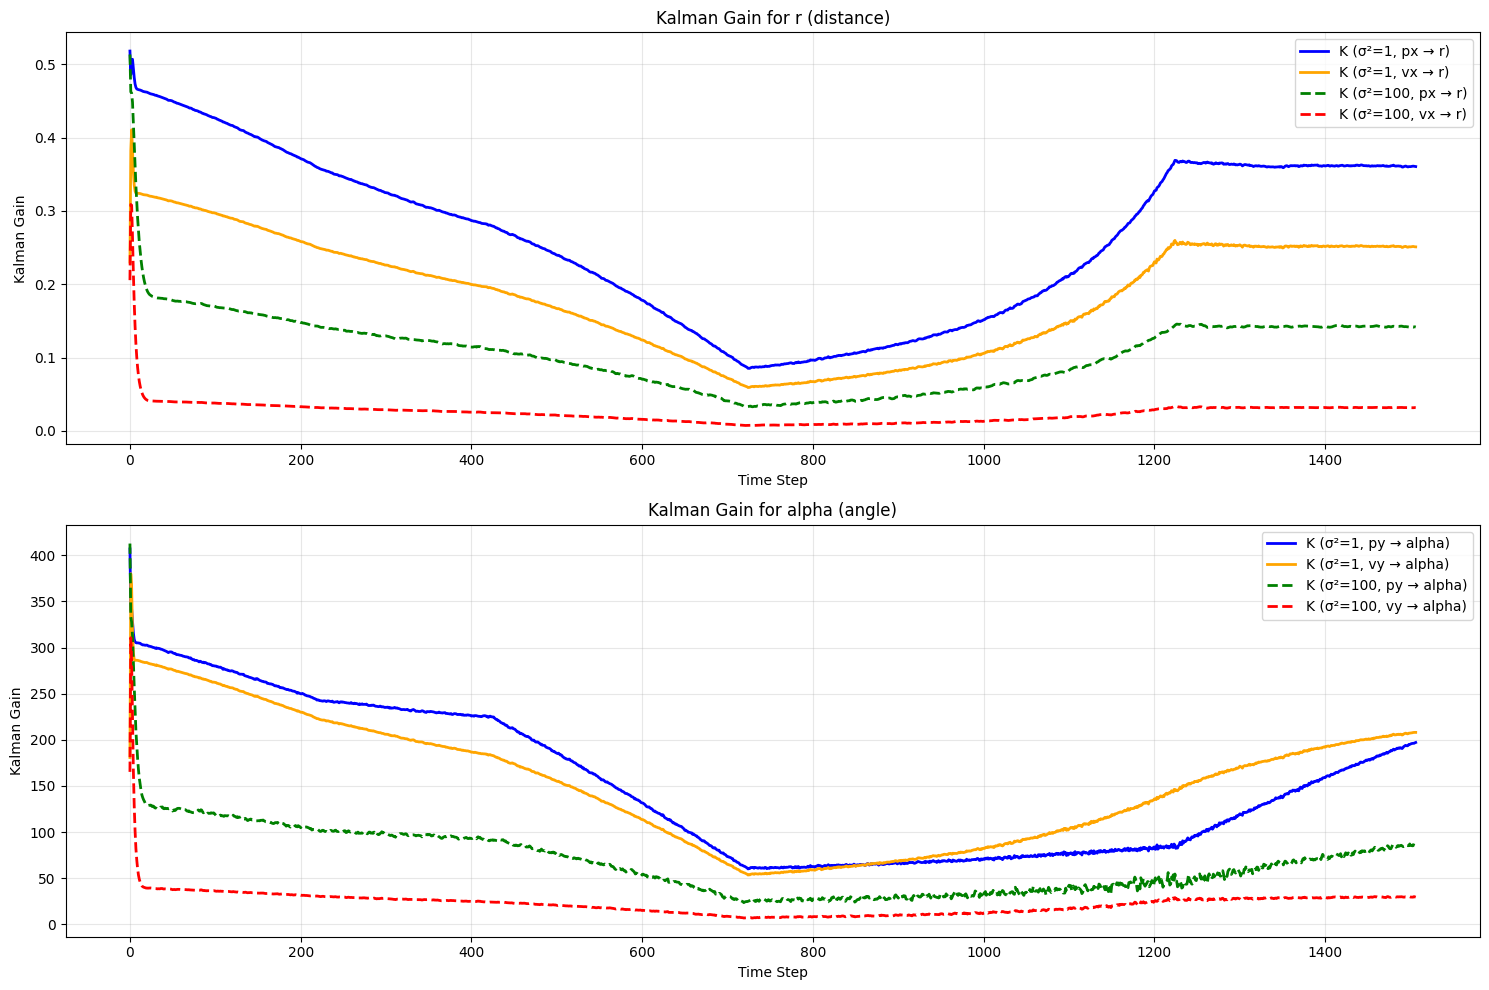


Kalman Gain Statistics:

Accurate Sensor (σ²=1):
Mean position gain (range): 0.2656
Mean velocity gain (range): 0.1850
Mean position gain (angle): 151.4200
Mean velocity gain (angle): 152.0722

Poor Sensor (σ²=100):
Mean position gain (range): 0.1067
Mean velocity gain (range): 0.0245
Mean position gain (angle): 66.8775
Mean velocity gain (angle): 22.7883


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_kalman_gains_comparison(K1_history, K2_history):
    """
    Plot direct comparison of Kalman gains between accurate and poor sensors
    """
    plt.figure(figsize=(15, 10))

    # Convert lists to arrays for easier indexing
    K1 = np.array(K1_history)
    K2 = np.array(K2_history)

    # Time steps for x-axis
    time_steps = np.arange(len(K1))

    # Plot range-related Kalman gains
    plt.subplot(211)
    # Position gains
    plt.plot(time_steps, K1[:, 0, 0], 'b-', label='K (σ²=1, px → r)', linewidth=2)
    plt.plot(time_steps, K1[:, 1, 0], 'orange', label='K (σ²=1, vx → r)', linewidth=2)
    plt.plot(time_steps, K2[:, 0, 0], 'g--', label='K (σ²=100, px → r)', linewidth=2)
    plt.plot(time_steps, K2[:, 1, 0], 'r--', label='K (σ²=100, vx → r)', linewidth=2)

    plt.title('Kalman Gain for r (distance)', fontsize=12)
    plt.xlabel('Time Step')
    plt.ylabel('Kalman Gain')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Plot angle-related Kalman gains
    plt.subplot(212)
    # Position gains for angle
    plt.plot(time_steps, K1[:, 2, 1], 'b-', label='K (σ²=1, py → alpha)', linewidth=2)
    plt.plot(time_steps, K1[:, 3, 1], 'orange', label='K (σ²=1, vy → alpha)', linewidth=2)
    plt.plot(time_steps, K2[:, 2, 1], 'g--', label='K (σ²=100, py → alpha)', linewidth=2)
    plt.plot(time_steps, K2[:, 3, 1], 'r--', label='K (σ²=100, vy → alpha)', linewidth=2)

    plt.title('Kalman Gain for alpha (angle)', fontsize=12)
    plt.xlabel('Time Step')
    plt.ylabel('Kalman Gain')
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    return plt.gcf()

# Run EKF and generate plots
def run_analysis_and_plot_gains(z1, z2):
    # Initialize system
    Ts = 0.5
    A = np.array([
        [1, Ts, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, Ts],
        [0, 0, 0, 1]
    ])

    sigma_q = 1
    Q = sigma_q * np.array([
        [Ts**4/4, Ts**3/2, 0, 0],
        [Ts**3/2, Ts**2, 0, 0],
        [0, 0, Ts**4/4, Ts**3/2],
        [0, 0, Ts**3/2, Ts**2]
    ])

    # Measurement noise covariances
    R1 = np.array([[1, 0], [0, 1e-6]])  # Accurate sensor
    R2 = np.array([[100, 0], [0, 1e-4]])  # Poor sensor

    # Initialize and run EKF for both measurements
    results = []
    for measurements, R in [(z1, R1), (z2, R2)]:
        x0 = initialize_state(measurements)
        P0 = np.eye(4) * R[0,0]

        ekf = ExtendedKalmanFilter(A, Q, R, x0, P0, Ts)
        filtered_states = ekf.filter(measurements)
        results.append(ekf.K)

    # Plot Kalman gains comparison
    K1, K2 = results
    plot_kalman_gains_comparison(K1, K2)
    plt.show()

    # Print some statistics about the Kalman gains
    print("\nKalman Gain Statistics:")
    print("\nAccurate Sensor (σ²=1):")
    print(f"Mean position gain (range): {np.mean(np.array(K1)[:, 0, 0]):.4f}")
    print(f"Mean velocity gain (range): {np.mean(np.array(K1)[:, 1, 0]):.4f}")
    print(f"Mean position gain (angle): {np.mean(np.array(K1)[:, 2, 1]):.4f}")
    print(f"Mean velocity gain (angle): {np.mean(np.array(K1)[:, 3, 1]):.4f}")

    print("\nPoor Sensor (σ²=100):")
    print(f"Mean position gain (range): {np.mean(np.array(K2)[:, 0, 0]):.4f}")
    print(f"Mean velocity gain (range): {np.mean(np.array(K2)[:, 1, 0]):.4f}")
    print(f"Mean position gain (angle): {np.mean(np.array(K2)[:, 2, 1]):.4f}")
    print(f"Mean velocity gain (angle): {np.mean(np.array(K2)[:, 3, 1]):.4f}")

# Call the analysis function with your data
run_analysis_and_plot_gains(z1, z2)

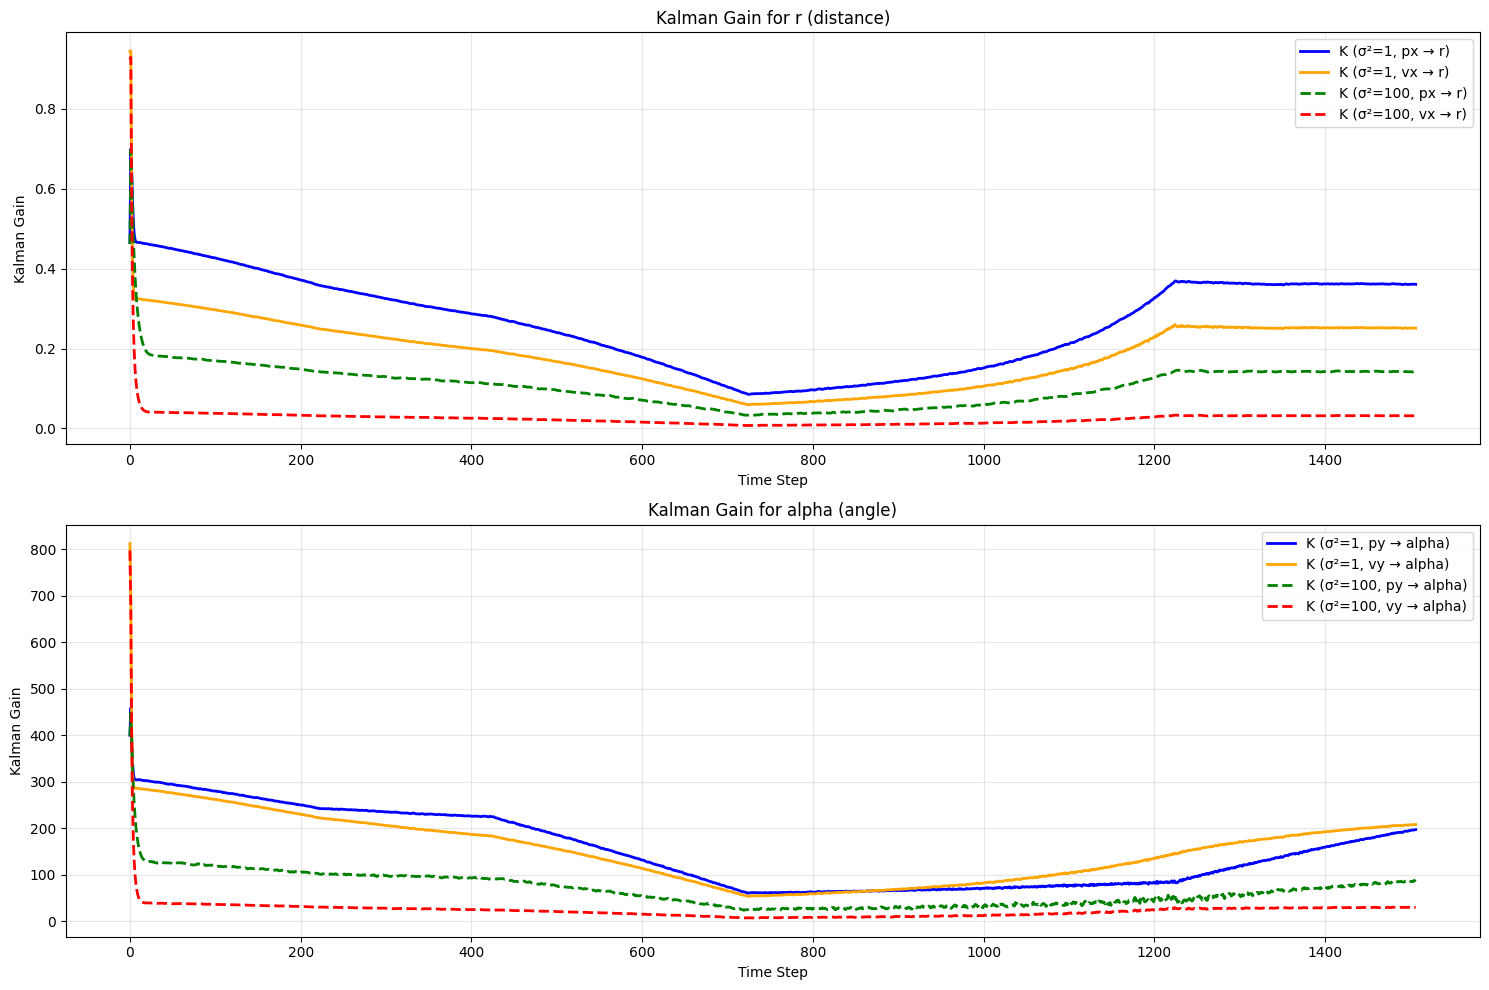


Kalman Gain Statistics:

Accurate Sensor (σ_r = 1):
Mean position gain (range): 0.2659
Mean velocity gain (range): 0.1860
Mean position gain (angle): 151.5357
Mean velocity gain (angle): 152.7397

Poor Sensor (σ_r = 10):
Mean position gain (range): 0.1070
Mean velocity gain (range): 0.0257
Mean position gain (angle): 66.9573
Mean velocity gain (angle): 23.5348


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def initialize_system(Ts=0.5, sigma_q=1):
    # State transition matrix
    A = np.array([
        [1, Ts, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, Ts],
        [0, 0, 0, 1]
    ])

    # Process noise covariance
    Q = sigma_q * np.array([
        [Ts**4/4, Ts**3/2, 0, 0],
        [Ts**3/2, Ts**2, 0, 0],
        [0, 0, Ts**4/4, Ts**3/2],
        [0, 0, Ts**3/2, Ts**2]
    ])

    return A, Q

def get_initial_conditions(sigma_r, Ts):
    """
    Returns initial state and covariance matrix as specified in equations (3.21) and (3.22)
    """
    # Initial state vector [px, vx, py, vy]
    x0 = np.array([500, 60, 200, 42])

    # Initial covariance matrix
    P0 = np.array([
        [sigma_r**2, -sigma_r**2/Ts, 0, 0],
        [-sigma_r**2/Ts, 2*sigma_r**2/Ts**2, 0, 0],
        [0, 0, sigma_r**2, -sigma_r**2/Ts],
        [0, 0, -sigma_r**2/Ts, 2*sigma_r**2/Ts**2]
    ])

    return x0, P0

def run_analysis_and_plot_gains(z1, z2):
    # System parameters
    Ts = 0.5
    sigma_q = 1
    A, Q = initialize_system(Ts, sigma_q)

    # Measurement noise parameters
    sigma_r1 = 1  # Accurate sensor
    sigma_r2 = 10  # Poor sensor (sqrt(100))

    # Measurement noise covariance matrices
    R1 = np.array([[sigma_r1**2, 0], [0, 1e-6*sigma_r1**2]])
    R2 = np.array([[sigma_r2**2, 0], [0, 1e-6*sigma_r2**2]])

    # Initialize and run EKF for both measurements
    results = []
    for measurements, R, sigma_r in [(z1, R1, sigma_r1), (z2, R2, sigma_r2)]:
        # Get initial conditions
        x0, P0 = get_initial_conditions(sigma_r, Ts)

        # Create and run EKF
        ekf = ExtendedKalmanFilter(A, Q, R, x0, P0, Ts)
        filtered_states = ekf.filter(measurements)
        results.append((filtered_states, ekf.K))

    # Plot results
    plot_kalman_gains_comparison(results[0][1], results[1][1])
    plt.show()

    # Print statistics
    print("\nKalman Gain Statistics:")
    for i, (states, K) in enumerate(results):
        sensor_type = "Accurate" if i == 0 else "Poor"
        sigma_r = sigma_r1 if i == 0 else sigma_r2
        print(f"\n{sensor_type} Sensor (σ_r = {sigma_r}):")
        print(f"Mean position gain (range): {np.mean(np.array(K)[:, 0, 0]):.4f}")
        print(f"Mean velocity gain (range): {np.mean(np.array(K)[:, 1, 0]):.4f}")
        print(f"Mean position gain (angle): {np.mean(np.array(K)[:, 2, 1]):.4f}")
        print(f"Mean velocity gain (angle): {np.mean(np.array(K)[:, 3, 1]):.4f}")

def plot_kalman_gains_comparison(K1_history, K2_history):
    """Plot direct comparison of Kalman gains between accurate and poor sensors"""
    plt.figure(figsize=(15, 10))

    K1 = np.array(K1_history)
    K2 = np.array(K2_history)
    time_steps = np.arange(len(K1))

    # Plot range-related gains
    plt.subplot(211)
    plt.plot(time_steps, K1[:, 0, 0], 'b-', label='K (σ²=1, px → r)', linewidth=2)
    plt.plot(time_steps, K1[:, 1, 0], 'orange', label='K (σ²=1, vx → r)', linewidth=2)
    plt.plot(time_steps, K2[:, 0, 0], 'g--', label='K (σ²=100, px → r)', linewidth=2)
    plt.plot(time_steps, K2[:, 1, 0], 'r--', label='K (σ²=100, vx → r)', linewidth=2)

    plt.title('Kalman Gain for r (distance)', fontsize=12)
    plt.xlabel('Time Step')
    plt.ylabel('Kalman Gain')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Plot angle-related gains
    plt.subplot(212)
    plt.plot(time_steps, K1[:, 2, 1], 'b-', label='K (σ²=1, py → alpha)', linewidth=2)
    plt.plot(time_steps, K1[:, 3, 1], 'orange', label='K (σ²=1, vy → alpha)', linewidth=2)
    plt.plot(time_steps, K2[:, 2, 1], 'g--', label='K (σ²=100, py → alpha)', linewidth=2)
    plt.plot(time_steps, K2[:, 3, 1], 'r--', label='K (σ²=100, vy → alpha)', linewidth=2)

    plt.title('Kalman Gain for alpha (angle)', fontsize=12)
    plt.xlabel('Time Step')
    plt.ylabel('Kalman Gain')
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    return plt.gcf()

# Run the analysis (assuming z1 and z2 are already loaded)
run_analysis_and_plot_gains(z1, z2)

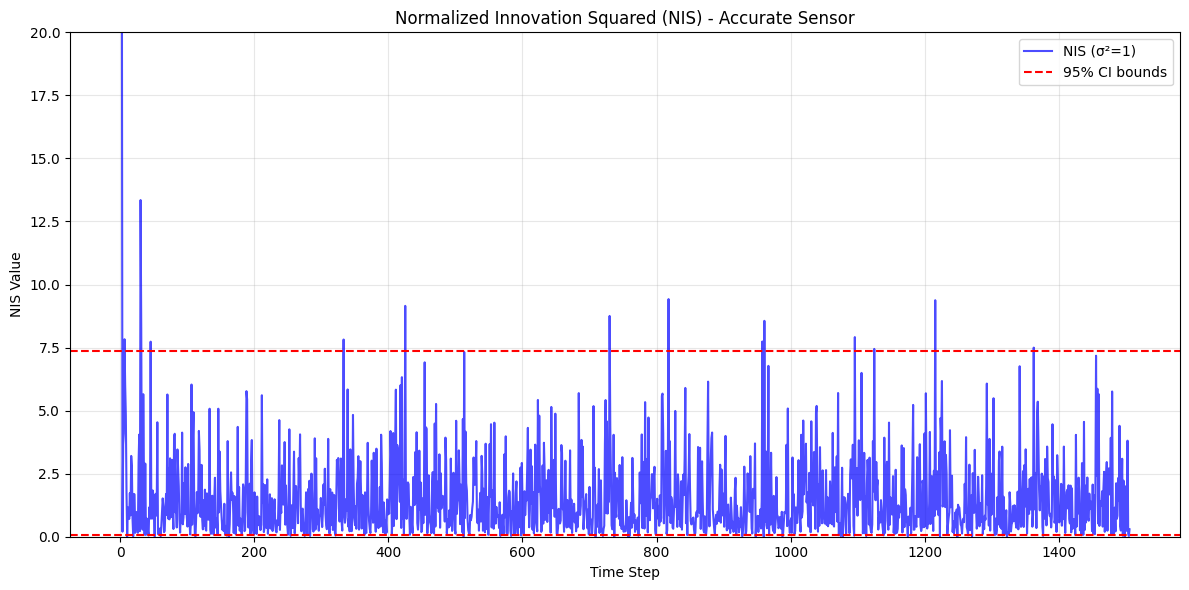

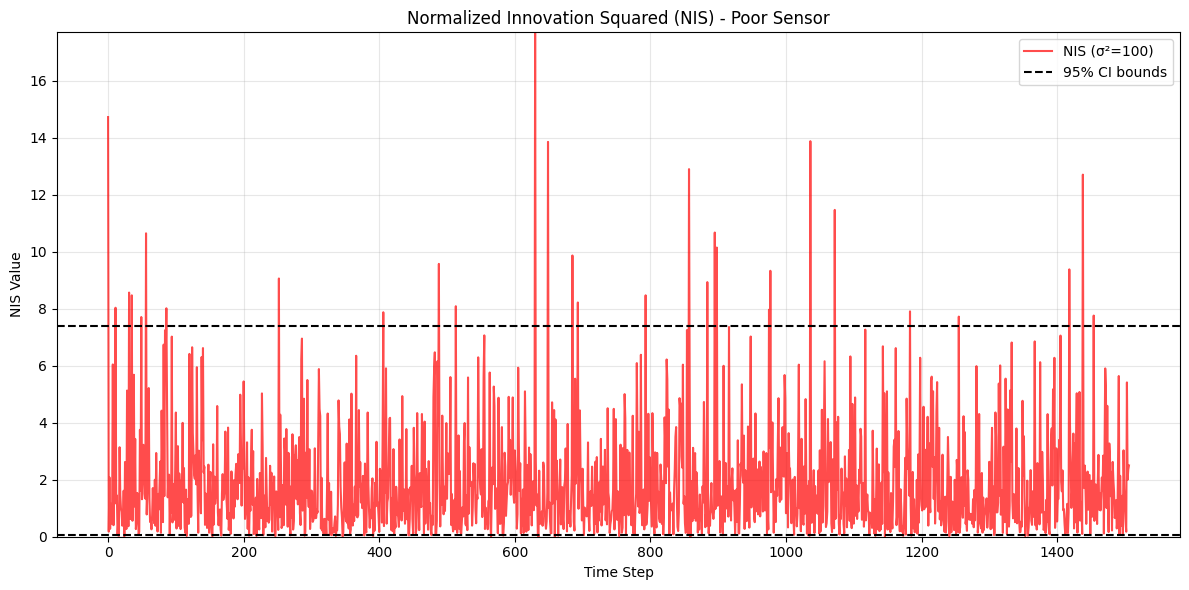


NIS Statistics:

Accurate Sensor (σ_r = 1):
Mean NIS: 2.17
Median NIS: 1.02
Percentage within 95% bounds: 96.4%

Poor Sensor (σ_r = 10):
Mean NIS: 1.88
Median NIS: 1.31
Percentage within 95% bounds: 96.0%


In [ ]:
def plot_nis_separately(nis_values1, nis_values2):
    """Create two separate plots for NIS values"""
    chi2_bounds = chi2.ppf([0.025, 0.975], df=2)
    time_steps = np.arange(len(nis_values1))

    # First figure: NIS for accurate sensor
    plt.figure(figsize=(12, 6))
    plt.plot(time_steps, nis_values1, 'b-', label='NIS (σ²=1)', alpha=0.7)
    plt.axhline(y=chi2_bounds[0], color='r', linestyle='--', label='95% CI bounds')
    plt.axhline(y=chi2_bounds[1], color='r', linestyle='--')

    plt.title('Normalized Innovation Squared (NIS) - Accurate Sensor', fontsize=12)
    plt.xlabel('Time Step')
    plt.ylabel('NIS Value')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.ylim(0, min(20, max(nis_values1)))
    plt.tight_layout()
    plt.savefig('nis_accurate_sensor.png', bbox_inches='tight', dpi=300)
    plt.show()  # Added show command

    # Second figure: NIS for poor sensor
    plt.figure(figsize=(12, 6))
    plt.plot(time_steps, nis_values2, 'r-', label='NIS (σ²=100)', alpha=0.7)
    plt.axhline(y=chi2_bounds[0], color='k', linestyle='--', label='95% CI bounds')
    plt.axhline(y=chi2_bounds[1], color='k', linestyle='--')

    plt.title('Normalized Innovation Squared (NIS) - Poor Sensor', fontsize=12)
    plt.xlabel('Time Step')
    plt.ylabel('NIS Value')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.ylim(0, min(20, max(nis_values2)))
    plt.tight_layout()
    plt.savefig('nis_poor_sensor.png', bbox_inches='tight', dpi=300)
    plt.show()  # Added show command

def run_nis_analysis(z1, z2):
    """Run analysis and create separate NIS plots"""
    # System parameters
    Ts = 0.5
    sigma_q = 1
    A, Q = initialize_system(Ts, sigma_q)

    # Measurement noise parameters
    sigma_r1 = 1  # Accurate sensor
    sigma_r2 = 10  # Poor sensor

    # Measurement noise covariance matrices
    R1 = np.array([[sigma_r1**2, 0], [0, 1e-6*sigma_r1**2]])
    R2 = np.array([[sigma_r2**2, 0], [0, 1e-6*sigma_r2**2]])

    # Initialize and run EKF for both measurements
    nis_values = []

    for measurements, R, sigma_r in [(z1, R1, sigma_r1), (z2, R2, sigma_r2)]:
        x0, P0 = get_initial_conditions(sigma_r, Ts)
        ekf = ExtendedKalmanFilter(A, Q, R, x0, P0, Ts)
        ekf.filter(measurements)
        nis_values.append(ekf.nis_values)

    # Create and display separate NIS plots
    plot_nis_separately(nis_values[0], nis_values[1])

    # Print NIS statistics
    print("\nNIS Statistics:")
    for i, nis in enumerate(nis_values):
        sensor_type = "Accurate" if i == 0 else "Poor"
        sigma_r = sigma_r1 if i == 0 else sigma_r2
        valid_nis = np.array(nis)[~np.isnan(nis)]

        print(f"\n{sensor_type} Sensor (σ_r = {sigma_r}):")
        print(f"Mean NIS: {np.mean(valid_nis):.2f}")
        print(f"Median NIS: {np.median(valid_nis):.2f}")
        in_bounds = np.sum((valid_nis >= chi2.ppf(0.025, df=2)) &
                          (valid_nis <= chi2.ppf(0.975, df=2)))
        percent_in_bounds = (in_bounds / len(valid_nis)) * 100
        print(f"Percentage within 95% bounds: {percent_in_bounds:.1f}%")

# Make sure to run this line to see the plots
run_nis_analysis(z1, z2)

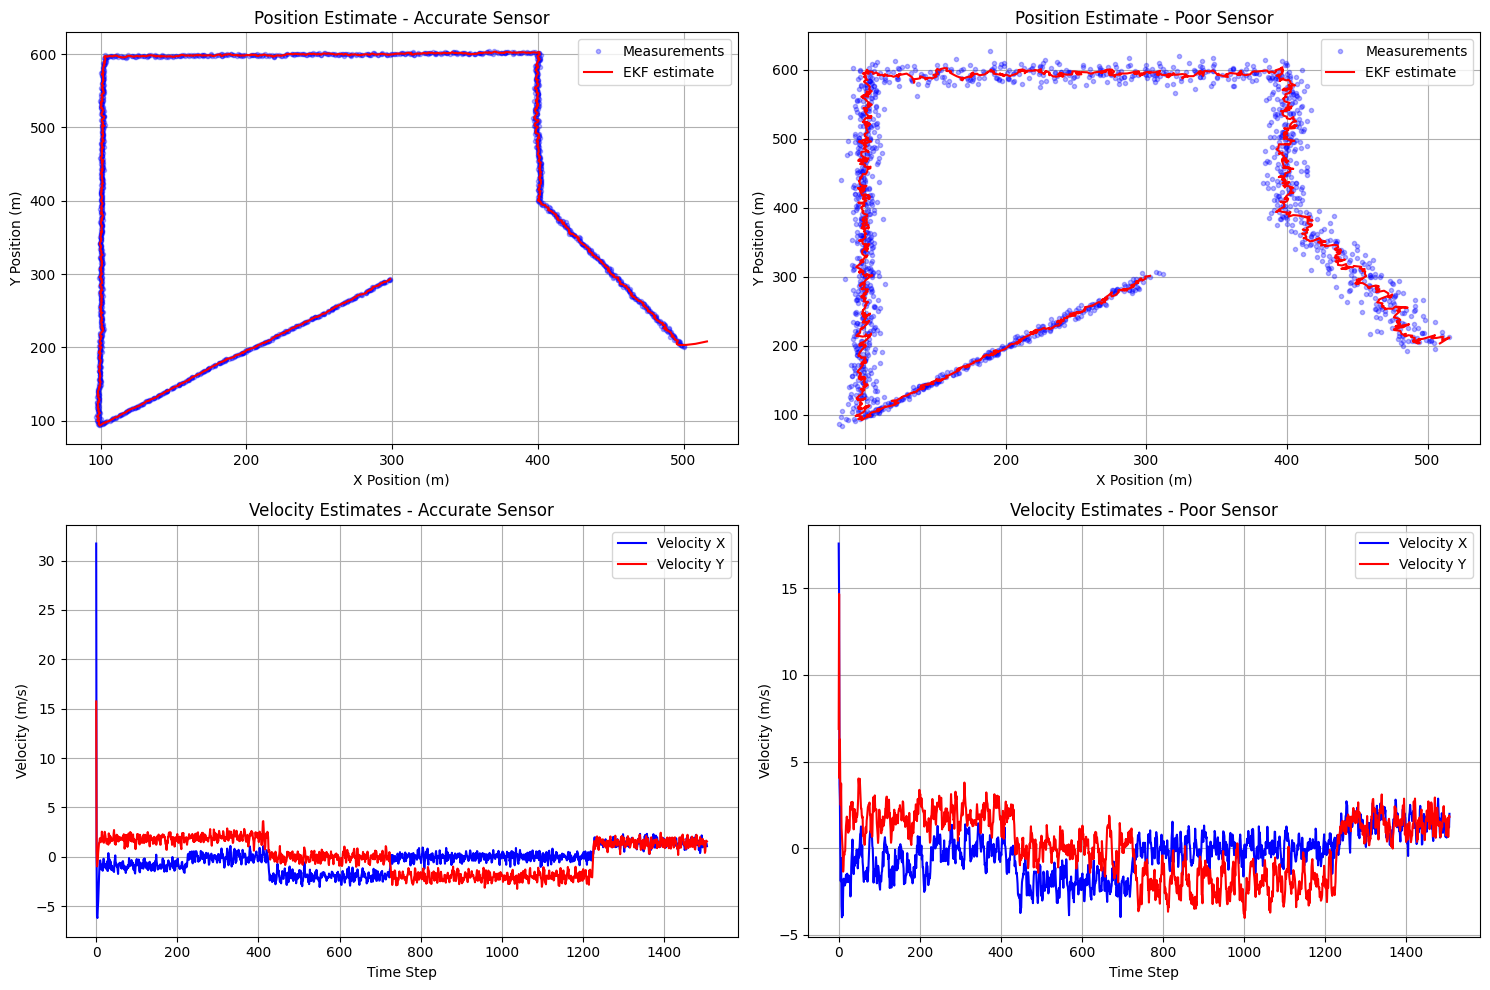

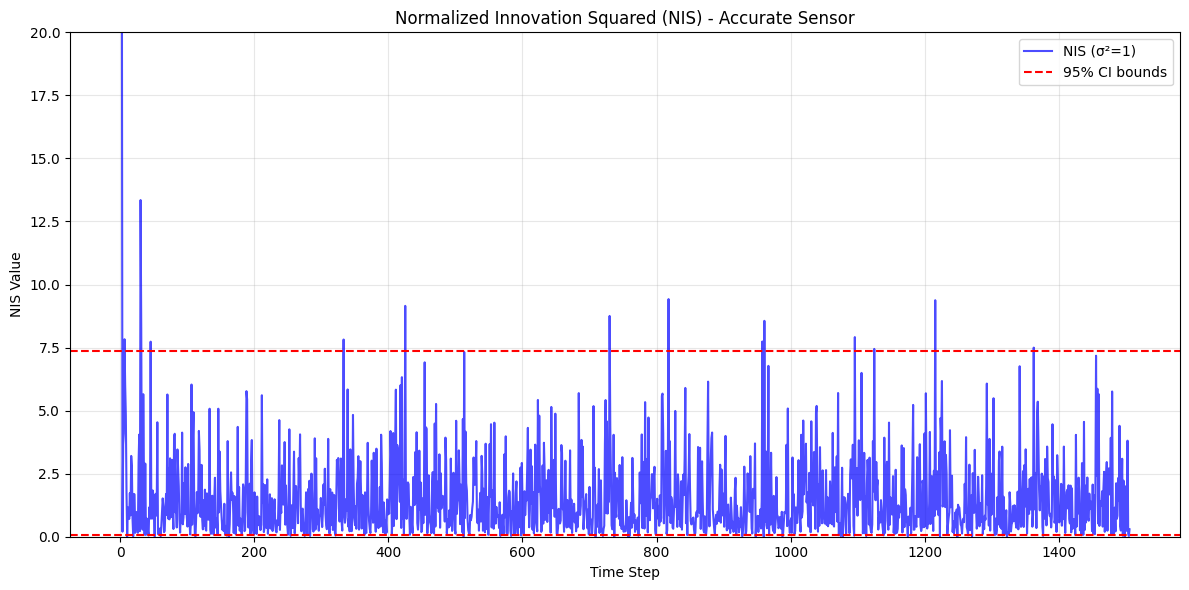

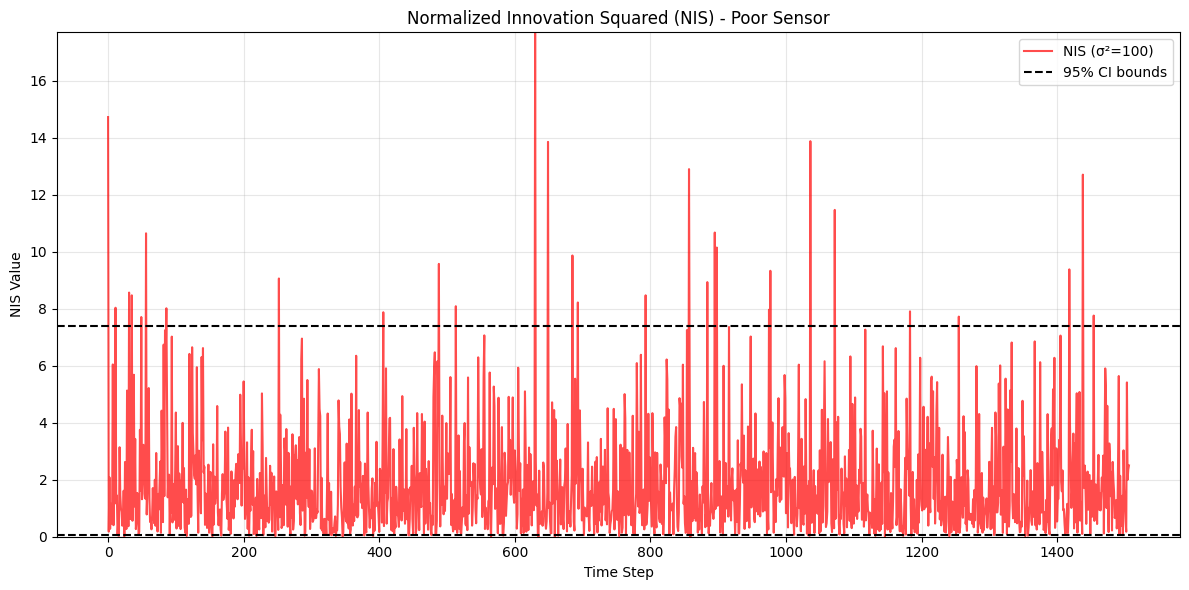

In [ ]:
def plot_state_estimates(states1, states2, z1, z2):
    plt.figure(figsize=(15, 10))

    # Convert measurements from polar to Cartesian
    def polar_to_cartesian(measurements):
        r = measurements[0, :]
        alpha = measurements[1, :]
        x = r * np.cos(alpha)
        y = r * np.sin(alpha)
        return x, y

    x1_meas, y1_meas = polar_to_cartesian(z1)
    x2_meas, y2_meas = polar_to_cartesian(z2)

    # Position plot for accurate sensor
    plt.subplot(221)
    plt.plot(x1_meas, y1_meas, 'b.', alpha=0.3, label='Measurements')
    plt.plot(states1[:, 0], states1[:, 2], 'r-', label='EKF estimate')
    plt.title('Position Estimate - Accurate Sensor')
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.grid(True)
    plt.legend()

    # Position plot for poor sensor
    plt.subplot(222)
    plt.plot(x2_meas, y2_meas, 'b.', alpha=0.3, label='Measurements')
    plt.plot(states2[:, 0], states2[:, 2], 'r-', label='EKF estimate')
    plt.title('Position Estimate - Poor Sensor')
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.grid(True)
    plt.legend()

    # Velocities plot for accurate sensor
    plt.subplot(223)
    plt.plot(states1[:, 1], 'b-', label='Velocity X')
    plt.plot(states1[:, 3], 'r-', label='Velocity Y')
    plt.title('Velocity Estimates - Accurate Sensor')
    plt.xlabel('Time Step')
    plt.ylabel('Velocity (m/s)')
    plt.grid(True)
    plt.legend()

    # Velocities plot for poor sensor
    plt.subplot(224)
    plt.plot(states2[:, 1], 'b-', label='Velocity X')
    plt.plot(states2[:, 3], 'r-', label='Velocity Y')
    plt.title('Velocity Estimates - Poor Sensor')
    plt.xlabel('Time Step')
    plt.ylabel('Velocity (m/s)')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def run_complete_analysis(z1, z2):
    # System parameters
    Ts = 0.5
    sigma_q = 1
    A, Q = initialize_system(Ts, sigma_q)

    # Measurement noise parameters
    sigma_r1 = 1
    sigma_r2 = 10

    R1 = np.array([[sigma_r1**2, 0], [0, 1e-6*sigma_r1**2]])
    R2 = np.array([[sigma_r2**2, 0], [0, 1e-6*sigma_r2**2]])

    states = []
    nis_values = []

    for measurements, R, sigma_r in [(z1, R1, sigma_r1), (z2, R2, sigma_r2)]:
        x0, P0 = get_initial_conditions(sigma_r, Ts)
        ekf = ExtendedKalmanFilter(A, Q, R, x0, P0, Ts)
        filtered_states = ekf.filter(measurements)
        states.append(filtered_states)
        nis_values.append(ekf.nis_values)

    # Plot state estimates
    plot_state_estimates(states[0], states[1], z1, z2)

    # Plot NIS values
    plot_nis_separately(nis_values[0], nis_values[1])

# Run the analysis
run_complete_analysis(z1, z2)